In [15]:
from keras import backend as K
from keras.layers import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.initializers import Initializer
from sklearn.cluster import KMeans
import numpy as np


import pandas as pd
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Activation
from keras.optimizers import RMSprop
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from os.path import join

In [85]:
PATH_TO_DB = 'D:\Projects\БММ\platelets'

Классы

In [74]:
class InitCentersRandom(Initializer):
    """ Initializer for initialization of centers of RBF network
        as random samples from the given data set.
    # Arguments
        X: matrix, dataset to choose the centers from (random rows
          are taken as centers)
    """

    def __init__(self, X):
        self.X = X

    def __call__(self, shape, dtype=None, **kwargs):
        assert shape[1] == self.X.shape[1]
        idx = np.random.randint(self.X.shape[0], size=shape[0])
        return self.X[idx, :]

In [75]:
class RBFLayer(Layer):
    """ Layer of Gaussian RBF units.
    # Example
    ```python
        model = Sequential()
        model.add(RBFLayer(10,
                           initializer=InitCentersRandom(X),
                           betas=1.0,
                           input_shape=(1,)))
        model.add(Dense(1))
    ```
    # Arguments
        output_dim: number of hidden units (i.e. number of outputs of the
                    layer)
        initializer: instance of initiliazer to initialize centers
        betas: float, initial value for betas
    """

    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     # initializer='ones',
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x, *args, **kwargs):

        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

        # C = self.centers[np.newaxis, :, :]
        # X = x[:, np.newaxis, :]

        # diffnorm = K.sum((C-X)**2, axis=-1)
        # ret = K.exp( - self.betas * diffnorm)
        # return ret

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))

In [76]:
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=1)
        km.fit(self.X)
        return km.cluster_centers_


In [86]:
df_th = pd.read_csv(join(PATH_TO_DB,'BD_platelets_regular.csv'), sep=';')
df_th

,r,eps,n,beta,0,0.5,1,1.5,2,2.5,...,85.5,86,86.5,87,87.5,88,88.5,89,89.5,90
0,0.5,0.1,1.3725,40,25.301178,25.209944,24.938040,24.490799,23.876934,23.108286,...,0.035687,0.040932,0.046830,0.053408,0.060684,0.068672,0.077375,0.086786,0.096886,0.107647
1,0.5,0.1,1.3725,42,25.253750,25.164614,24.898931,24.461840,23.861731,23.110008,...,0.110150,0.120814,0.131986,0.143610,0.155616,0.167922,0.180437,0.193053,0.205656,0.218120
2,0.5,0.1,1.3725,44,25.202293,25.115267,24.855852,24.428991,23.842764,23.108150,...,0.219127,0.230691,0.241920,0.252689,0.262871,0.272336,0.280954,0.288599,0.295148,0.300487
3,0.5,0.1,1.3725,46,25.143423,25.058531,24.805452,24.388945,23.816780,23.099533,...,0.305602,0.309963,0.313069,0.314847,0.315234,0.314183,0.311665,0.307667,0.302198,0.295287
4,0.5,0.1,1.3725,48,25.076042,24.993305,24.746632,24.340595,23.782681,23.083057,...,0.312300,0.304946,0.296285,0.286385,0.275334,0.263235,0.250206,0.236381,0.221905,0.206933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196139,2.1,1.0,1.3875,82,214711.812500,212251.640600,205016.031300,193427.546900,178150.890600,160037.921900,...,1.374523,1.331677,1.215894,1.043869,0.838637,0.626118,0.431531,0.276193,0.175054,0.135262
196140,2.1,1.0,1.3875,84,214710.484400,212250.328100,205014.765600,193426.375000,178149.843800,160037.015600,...,1.377804,1.336296,1.221435,1.049784,0.844330,0.631035,0.435245,0.278462,0.175858,0.134800
196141,2.1,1.0,1.3875,86,214710.375000,212250.218800,205014.671900,193426.281300,178149.765600,160036.968800,...,1.384726,1.344976,1.231294,1.060079,0.854240,0.639758,0.442089,0.282927,0.177689,0.134010
196142,2.1,1.0,1.3875,88,214711.218800,212251.046900,205015.484400,193427.046900,178150.500000,160037.640600,...,1.388198,1.349743,1.237083,1.066495,0.860799,0.645923,0.447320,0.286726,0.179647,0.133848


In [30]:
columns_to_keep = ['r', 'eps', 'n', 'beta'] + [str(column) for column in range(10, 70)]
df_th = df_th[columns_to_keep]

In [31]:
X = df_th.iloc[:, 4:]

In [32]:
y = df_th[['r', 'eps', 'n', 'beta']]

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
Xvse_scaled = scaler_X.fit_transform(X)

# # Создание экземпляра MinMaxScaler для нормализации y
scaler_y = MinMaxScaler()
y_scaled= scaler_y.fit_transform(y)

In [34]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [35]:
X_train, X_test, y_train, y_test = train_test_split(Xvse_scaled , y_scaled, test_size=0.25)

In [36]:
InitCentersKMeans(X_train)

In [77]:
model = Sequential()
rbflayer = RBFLayer(512,
                    initializer=InitCentersKMeans(X_train),
                    betas=3.0,
                    input_shape=(60,))
model.add(rbflayer)
model.add(Dense(512))
# model.add(RBFLayer(256, betas=3.0))
model.add(Dense(64))
model.add(Dense(4))
model.add(Activation('relu'))

d:\projects\бмм\rbf_neural_network_python\venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Initialization complete
Iteration 0, inertia 1273.3595035944609.
Iteration 1, inertia 1060.8525415767808.
Iteration 2, inertia 1034.027884641259.
Iteration 3, inertia 1023.1752111144532.
Iteration 4, inertia 1016.3344182139796.
Iteration 5, inertia 1011.5848531029038.
Iteration 6, inertia 1007.96270931433.
Iteration 7, inertia 1005.0730435715755.
Iteration 8, inertia 1002.9158892079107.
Iteration 9, inertia 1001.1594077908791.
Iteration 10, inertia 999.613946004986.
Iteration 11, inertia 998.2511168909446.
Iteration 12, inertia 997.0372705582809.
Iteration 13, inertia 995.9724214834584.
Iteration 14, inertia 995.0488741575234.
Iteration 15, inertia 994.1521072422228.
Iteration 16, inertia 993.438054459006.
Iteration 17, inertia 992.846353578669.
Iteration 18, inertia 992.3803390107151.
Iteration 19, inertia 991.9516131517488.
Iteration 20, inertia 991.5188121835324.
Iteration 21, inertia 991.1312296554479.
Iteration 22, inertia 990.8127974815937.
Iteration 23, inertia 990.5299403014102

Initialization complete
Iteration 0, inertia 1276.622460329249.
Iteration 1, inertia 1068.865127863845.
Iteration 2, inertia 1041.5654781074365.
Iteration 3, inertia 1028.2677481754731.
Iteration 4, inertia 1019.486008443256.
Iteration 5, inertia 1013.252876817783.
Iteration 6, inertia 1008.6518059398918.
Iteration 7, inertia 1005.0021519780562.
Iteration 8, inertia 1002.2166155276973.
Iteration 9, inertia 1000.0343597647384.
Iteration 10, inertia 998.4076106976371.
Iteration 11, inertia 997.1625795875975.
Iteration 12, inertia 996.0522312301364.
Iteration 13, inertia 995.1290365894619.
Iteration 14, inertia 994.3324966875164.
Iteration 15, inertia 993.7566366378435.
Iteration 16, inertia 993.2694629849024.
Iteration 17, inertia 992.8079971476466.
Iteration 18, inertia 992.3869618217822.
Iteration 19, inertia 992.0459337858666.
Iteration 20, inertia 991.708757062585.
Iteration 21, inertia 991.403447326522.
Iteration 22, inertia 991.0847256117689.
Iteration 23, inertia 990.8023378157025

Initialization complete
Iteration 0, inertia 1273.6706228300723.
Iteration 1, inertia 1060.5346502781965.
Iteration 2, inertia 1033.0388316319436.
Iteration 3, inertia 1021.7030649640899.
Iteration 4, inertia 1014.4560970326295.
Iteration 5, inertia 1009.5804933882762.
Iteration 6, inertia 1006.0762952054629.
Iteration 7, inertia 1003.3914802108461.
Iteration 8, inertia 1001.3286346781985.
Iteration 9, inertia 999.4509405093679.
Iteration 10, inertia 997.8979201222667.
Iteration 11, inertia 996.7514865389996.
Iteration 12, inertia 995.8825204563786.
Iteration 13, inertia 995.1504505828292.
Iteration 14, inertia 994.4877983738523.
Iteration 15, inertia 993.9029808399422.
Iteration 16, inertia 993.3609812185232.
Iteration 17, inertia 992.7607817395151.
Iteration 18, inertia 992.2328350376794.
Iteration 19, inertia 991.7685410438984.
Iteration 20, inertia 991.3294320333254.
Iteration 21, inertia 990.9249247383308.
Iteration 22, inertia 990.577043044394.
Iteration 23, inertia 990.259865947

Initialization complete
Iteration 0, inertia 1288.2533541295065.
Iteration 1, inertia 1071.9427070247555.
Iteration 2, inertia 1043.8841526350348.
Iteration 3, inertia 1031.101912502568.
Iteration 4, inertia 1022.9902074388427.
Iteration 5, inertia 1017.460199146902.
Iteration 6, inertia 1013.5114593928702.
Iteration 7, inertia 1010.456498917514.
Iteration 8, inertia 1008.2406738977581.
Iteration 9, inertia 1006.5261931465302.
Iteration 10, inertia 1004.8506231873698.
Iteration 11, inertia 1003.4491031669843.
Iteration 12, inertia 1002.2909987001906.
Iteration 13, inertia 1001.1790354804318.
Iteration 14, inertia 1000.2145966785686.
Iteration 15, inertia 999.4115832036358.
Iteration 16, inertia 998.6672948502197.
Iteration 17, inertia 997.9764449221462.
Iteration 18, inertia 997.3778691231223.
Iteration 19, inertia 996.8744093694037.
Iteration 20, inertia 996.3553152492004.
Iteration 21, inertia 996.02531517639.
Iteration 22, inertia 995.7732028393572.
Iteration 23, inertia 995.5501830

Initialization complete
Iteration 0, inertia 1277.9426146309377.
Iteration 1, inertia 1060.3001234353615.
Iteration 2, inertia 1032.4066921882795.
Iteration 3, inertia 1020.224645770714.
Iteration 4, inertia 1013.3688500763545.
Iteration 5, inertia 1008.8186681961749.
Iteration 6, inertia 1005.463692015818.
Iteration 7, inertia 1002.833354848327.
Iteration 8, inertia 1000.477630296909.
Iteration 9, inertia 998.5349602832788.
Iteration 10, inertia 996.9330885730415.
Iteration 11, inertia 995.5382754032025.
Iteration 12, inertia 994.3836342386817.
Iteration 13, inertia 993.3358241558014.
Iteration 14, inertia 992.5009798775857.
Iteration 15, inertia 991.7477284994034.
Iteration 16, inertia 991.0928478064101.
Iteration 17, inertia 990.4890819423331.
Iteration 18, inertia 989.960010608853.
Iteration 19, inertia 989.4618449388898.
Iteration 20, inertia 989.0842122861552.
Iteration 21, inertia 988.7890308433143.
Iteration 22, inertia 988.5278531853958.
Iteration 23, inertia 988.2554853165034

In [78]:
model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(), metrics=['accuracy'])
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rbf_layer_11 (RBFLayer)     (None, 512)               31232     
                                                                 
 dense_13 (Dense)            (None, 512)               262656    
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Dense)            (None, 4)                 260       
                                                                 
 activation_6 (Activation)   (None, 4)                 0         
                                                                 
Total params: 326980 (1.25 MB)
Trainable params: 326980 (1.25 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [79]:
len(model.weights)

8

In [80]:
history = model.fit(x=X_train, y=y_train, batch_size=64, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
2299/2299 [==============================] - 36s 15ms/step - loss: 0.1989 - accuracy: 0.3665 - val_loss: 0.0594 - val_accuracy: 0.4607
Epoch 2/5
2299/2299 [==============================] - 35s 15ms/step - loss: 0.0542 - accuracy: 0.5190 - val_loss: 0.0515 - val_accuracy: 0.5548
Epoch 3/5
2299/2299 [==============================] - 35s 15ms/step - loss: 0.0513 - accuracy: 0.5367 - val_loss: 0.0506 - val_accuracy: 0.5361
Epoch 4/5
2299/2299 [==============================] - 35s 15ms/step - loss: 0.0497 - accuracy: 0.5467 - val_loss: 0.0548 - val_accuracy: 0.5207
Epoch 5/5
2299/2299 [==============================] - 36s 16ms/step - loss: 0.0487 - accuracy: 0.5553 - val_loss: 0.0494 - val_accuracy: 0.5544


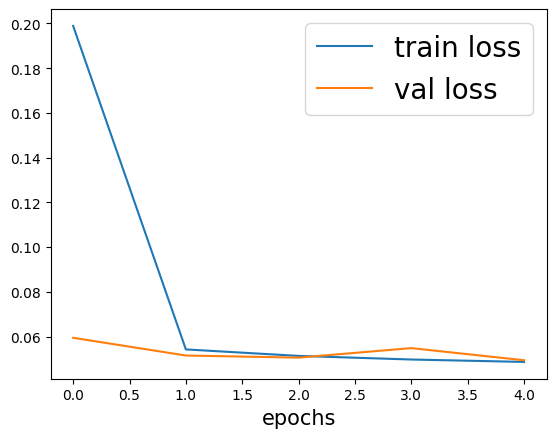

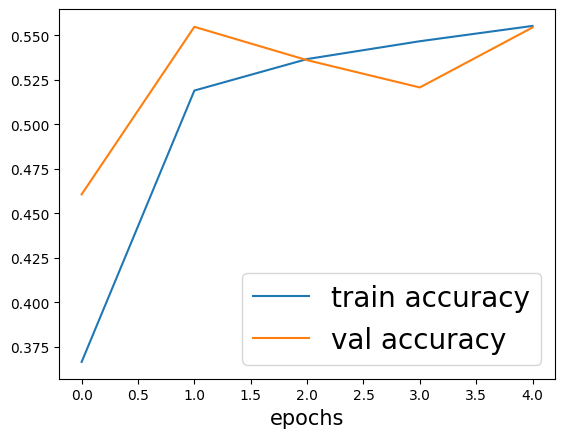

In [81]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epochs', fontsize=15)
plt.legend(fontsize=20)
plt.show()

In [82]:
preds = model.predict(X_test)

1533/1533 [==============================] - 5s 3ms/step


In [83]:
from sklearn.metrics import r2_score, median_absolute_error,mean_squared_error
from math import sqrt


print(
f'r2 = {r2_score(y_test, preds):.2f} MedAE = {median_absolute_error(y_test, preds):.2f}',
f'r2 = {r2_score(y_test, preds):.2f} MSE = {mean_squared_error(y_test, preds):.2f}',sep='\n')

r2 = 0.56 MedAE = 0.12
r2 = 0.56 MSE = 0.05


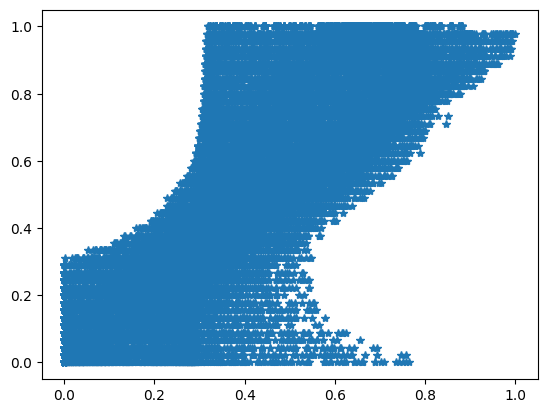

In [84]:
plt.plot(preds[:, 1], y_test[:,1], '*')